In [1]:
import numpy as np
import pandas as pd
import pickle
import random

In [2]:
tr_labels = pd.read_csv('../../data/small_ntu_frames/train_labels', header=None)
v_labels = pd.read_csv('../../data/small_ntu_frames/val_labels', header=None)

with open('../../data/mini_ntu_frames/mini_train_data.pkl', 'rb') as f:
    tr_dict = pickle.load(f)
with open('../../data/mini_ntu_frames/mini_val_data.pkl', 'rb') as f:
    v_dict = pickle.load(f)

In [3]:
def flatten_frames(arr_3d):
    n_frames = arr_3d.shape[0]
    temp_arr = np.zeros((n_frames, 48))
    for i in range(n_frames):
        arr_3d[i, :, :] = arr_3d[i, :, :] - arr_3d[i, 2, :]
        temp_arr[i, :] = np.reshape(arr_3d[i, :, :], (1, -1))
    return temp_arr

In [4]:
def flatten_dict(d_dict):
    for i in d_dict:
        d_dict[i] = flatten_frames(d_dict[i])
    return d_dict

t1 = flatten_dict(tr_dict)

In [5]:
def data_gen(d_dict, d_labels):
    while(True):
        d_id = random.sample(list(d_dict), 1)[0]
        databatch = d_dict[d_id]
        if 'train' in d_id:
            idx = int(d_id.replace('train', ''))
            label = d_labels.iloc[idx, 1]
        elif 'val' in d_id:
            idx = int(d_id.replace('val', ''))
            label = d_labels.iloc[idx, 1]
        yield databatch,label

Dtr = data_gen(t1, tr_labels)

In [6]:
next(Dtr)

(array([[  4.        ,  92.0625    , -10.51473999, ...,  16.        ,
           8.25      , -28.10903931],
        [  0.        ,  84.        ,  -5.82763672, ..., -24.        ,
         -16.375     , -13.75427246],
        [ 12.        ,  84.1875    ,  -6.41049194, ...,  32.        ,
          12.5       , -17.23303223],
        ..., 
        [ -4.        ,  87.9375    ,  -8.84054565, ..., -52.        ,
         -16.8125    , -26.60339355],
        [-20.        ,  91.6875    ,  -3.63687134, ...,  48.        ,
         -59.25      , -23.83166504],
        [ 12.        ,  84.1875    ,  -2.90161133, ...,  32.        ,
          12.5       , -17.22859192]]), 6)

In [7]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random, numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
#action LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, joints_dim, hidden_dim, label_size, batch_size, num_layers, kernel_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        joints_dim2d = joints_dim - 16
        
        self.lstm3 = nn.LSTM(joints_dim, hidden_dim, num_layers=self.num_layers)
        self.conv1_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
        self.lstm2_1 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_1 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_2 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_2 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        self.lstm2_3 = nn.LSTM(joints_dim2d, hidden_dim, num_layers=self.num_layers)
        self.conv1_2_3 = nn.Conv1d(1, 1, kernel_size, stride=1, padding=1)
        
#         self.conv1_1 = nn.Conv1d(4, 2, kernel_size, stride=1, padding=1) #for kernel size=3
#         self.conv1_2 = nn.Conv1d(2, 1, kernel_size, stride=1, padding=1) #for kernel size=3
        
        self.hidden3 = self.init_hidden3()
        self.hidden2_1 = self.init_hidden2_1()
        self.hidden2_2 = self.init_hidden2_2()
        self.hidden2_3 = self.init_hidden2_3()
        
        self.hidden2label = nn.Linear(hidden_dim, label_size)
    
    def init_hidden3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_1(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_2(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    def init_hidden2_3(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()),
                autograd.Variable(torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).cuda()))
    
    
    def forward(self, joints3d_vec):
        x3 = joints3d_vec
        x2 = x3.view(-1, 16, 3)
        x2_1 = x2[:,:,1:3].contiguous().view(-1, 1, 32)
        x2_2 = x2[:,:,0:2].contiguous().view(-1, 1, 32)
        x2_3 = x2[:,:,[0,2]].contiguous().view(-1, 1, 32)
#         print('x2_3 : ',x2_3.size())
        lstm_out3, self.hidden3 = self.lstm3(x3, self.hidden3)
        lstm_out2_1, self.hidden2_1 = self.lstm2_1(x2_1, self.hidden2_1)
        lstm_out2_2, self.hidden2_2 = self.lstm2_2(x2_2, self.hidden2_2)
        lstm_out2_3, self.hidden2_3 = self.lstm2_3(x2_3, self.hidden2_3)
#         print('lstm_out[-1] : ', lstm_out[-1].size())
        t3 = lstm_out3[-1].view(self.batch_size,1,-1)
#         print('t3 : ', t3.size())
        t2_1 = lstm_out2_1[-1].view(self.batch_size,1,-1)
        t2_2 = lstm_out2_2[-1].view(self.batch_size,1,-1)
        t2_3 = lstm_out2_3[-1].view(self.batch_size,1,-1)
#         print('t2_3 : ', t2_3.size())
        
#         t = autograd.Variable(torch.zeros(self.batch_size, 4, self.hidden_dim).cuda())
#         t[:,0,:] = t3
#         t[:,1,:] = t2_1
#         t[:,2,:] = t2_2
#         t[:,3,:] = t2_3
#         print('t : ', t.size())
        
        y3 = self.conv1_3(t3)
#         print('y3 : ', y3.size())
        y2_1 = self.conv1_2_1(t2_1)
#         print('y2_1 : ', y2_1.size())
        y2_2 = self.conv1_2_2(t2_2)
#         print('y2_2 : ', y2_2.size())
        y2_3 = self.conv1_2_3(t2_3)
#         print('y2_3 : ', y2_3.size())
        
        y3 += y2_1+y2_2+y2_3
        
        y3 = y3.contiguous().view(-1, self.hidden_dim)
#         print('y3 : ', y3.size())
        
        y  = self.hidden2label(y3)
        log_probs = F.softmax(y, dim=1)
        return log_probs
#instanstiating a model
model0 = LSTMClassifier(48, 512, 13, 1, 2, 3)
#to do stuff in CUDA
model0 = model0.cuda()

In [10]:
output = autograd.Variable(torch.rand(1,13))
target = autograd.Variable(torch.LongTensor([1]))

print(output, target)

criterion = nn.CrossEntropyLoss()
loss = criterion(output, target)
print(loss)

Variable containing:

Columns 0 to 9 
 0.4216  0.3553  0.1027  0.0555  0.5771  0.6873  0.7183  0.4206  0.0443  0.8783

Columns 10 to 12 
 0.6960  0.7852  0.9737
[torch.FloatTensor of size 1x13]
 Variable containing:
 1
[torch.LongTensor of size 1]

Variable containing:
 2.7696
[torch.FloatTensor of size 1]



In [17]:
#training function
def train(model, num_epoch, num_iter, rec_interval, disp_interval):
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    loss_values = []
    avg_loss_values = []
    rec_step = 0
    criterion = nn.CrossEntropyLoss()
    print('Starting the training ...')
    for eph in range(num_epoch):
        print('epoch {} starting ...'.format(eph))
        avg_loss = 0
        n_samples = 0
        for i in range(num_iter):
            model.hidden3 = (model.hidden3[0].detach(), model.hidden3[1].detach())
            model.hidden2_1 = (model.hidden2_1[0].detach(), model.hidden2_1[1].detach())
            model.hidden2_2 = (model.hidden2_2[0].detach(), model.hidden2_2[1].detach())
            model.hidden2_3 = (model.hidden2_3[0].detach(), model.hidden2_3[1].detach())
            model.zero_grad()
            X,Y = next(Dtr)
            n_samples += len(X)
            X = autograd.Variable(torch.from_numpy(X).float()).cuda()
            X1 = X.view(len(X), 1, -1)
            Y = autograd.Variable(torch.LongTensor(np.array([Y]))).cuda()

            y_hat = model(X1)
#             print('before loss \n', y_hat, Y)
            loss = criterion(y_hat, Y)
#             loss_n = loss.data[0]
#             print('after loss \n', eph, i, y_hat, loss_n)
            avg_loss += loss.data[0]
            
            if i % disp_interval == 0:
                print('epoch: %d iterations: %d loss :%g' % (eph, i, loss.data[0]))
            if rec_step%rec_interval==0:
                loss_values.append(loss.data[0])
            
            loss.backward()     
            optimizer.step()
            rec_step += 1
            
        avg_loss /= n_samples
        avg_loss_values.append(avg_loss)
#         #evaluating model accuracy
# #         acc = evaluate_accuracy(model, test_split)
        print('epoch: {} <====train track===> avg_loss: {}, accuracy \n'.format(eph, avg_loss))
    return loss_values, avg_loss_values

Starting the training ...
epoch 0 starting ...
epoch: 0 iterations: 0 loss :1.68911
epoch: 0 iterations: 10 loss :1.6891
epoch: 0 iterations: 20 loss :1.68909
epoch: 0 iterations: 30 loss :1.68909
epoch: 0 iterations: 40 loss :1.68909
epoch: 0 iterations: 50 loss :1.68909
epoch: 0 iterations: 60 loss :1.68909
epoch: 0 iterations: 70 loss :1.68909
epoch: 0 iterations: 80 loss :1.68909
epoch: 0 iterations: 90 loss :1.68909
epoch: 0 <====train track===> avg_loss: 0.020296728702669846, accuracy 

epoch 1 starting ...
epoch: 1 iterations: 0 loss :1.68909
epoch: 1 iterations: 10 loss :1.68909
epoch: 1 iterations: 20 loss :1.68909
epoch: 1 iterations: 30 loss :1.68909
epoch: 1 iterations: 40 loss :1.68909
epoch: 1 iterations: 50 loss :1.68909
epoch: 1 iterations: 60 loss :1.68909
epoch: 1 iterations: 70 loss :1.68909
epoch: 1 iterations: 80 loss :1.68909
epoch: 1 iterations: 90 loss :1.68909
epoch: 1 <====train track===> avg_loss: 0.02058109755462018, accuracy 

epoch 2 starting ...
epoch: 2 

Text(0,0.5,'avg loss')

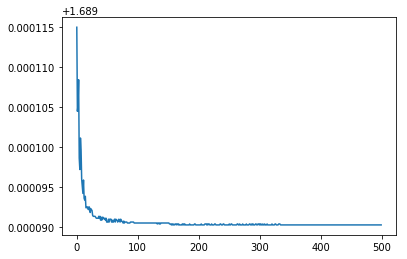

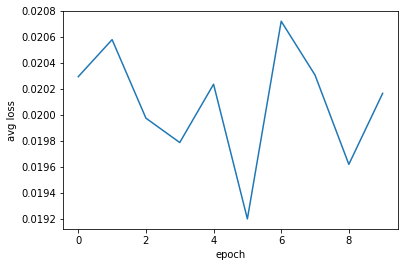

In [18]:
loss_vals, avg_loss_vals = train(model0, 10, 100, 2, 10) #100eph_8e-6, 
plt.figure()
plt.plot(loss_vals)
plt.figure()
plt.plot(avg_loss_vals)
plt.xlabel('epoch')
plt.ylabel('avg loss')

In [25]:
z = torch.rand(3)
print(z)
np.argmax(z.numpy())


 0.1454
 0.4330
 0.2739
[torch.FloatTensor of size 3]



1